# Consultando Wikidata

En este tutorial, navegaremos en el Grafo de Conocimiento Wikidata y realizaremos consultas y visualizaciones con sus datos. Además, aprenderemos a utilizar el lenguaje de consulta SPARQL.

Algunos links útiles para la sesión: a [la página principal de Wikidata](https://www.wikidata.org) y a [su terminal de consulta en SPARQL](https://query.wikidata.org/)

## RDF

RDF es la recomendación de la W3C para almacenar información organizada como grafo en la Web. La unidad básica de información en RDF son los triples. Un triple `(x, y, z)` representa una arista dirigida en el grafo, donde `x` es el nodo fuente, `y` es la etiqueta de la arista y `z` es el nodo objetivo. También, `x` se puede llamar el "sujeto", `y` el "predicado", y `z` el "objeto".

Por ejemplo, el triple RDF `(Chile, capital, Santiago)` indica que existe una relación de tipo `capital` entre los nodos `Chile` y `Santiago`. Se lee "Chile tiene capital Santiago".

Los valores que pueden tomar `x`, `y` y `z` están restringidos. El objeto y predicado de un triple RDF solo puede contener IRIs, identificadores internacionales de recursos, que lucen como una dirección de un recurso en la Web. Una IRI que representa a Chile es, por ejemplo, https://dbpedia.org/resource/Chile. Los objetos pueden ser IRIs, pero también pueden ser valores tipados como números, fechas y strings.

Entonces, un triple RDF "más real" luciría por ejemplo `(https://dbpedia.org/resource/Chile, https://dbpedia.org/ontology/capital, https://dbpedia.org/resource/Santiago)`. Un poco largo, ¿no? Por esto, se utilizan formas abreviadas para solo mantener la parte relevante de las IRIs. Usando los espacios de nombres `dbr:` para `https://dbpedia.org/resource/` y `dbo` para `https://dbpedia.org/ontology/`, el triple anterior se puede escribir como `(dbr:Chile, dbo:capital, dbr:Santiago)`.

Finalmente, un conjunto de triples RDF conforman un grafo RDF. Por ejemplo, el siguiente (usando los espacios de nombres previamente introducidos):

```sparql
(dbr:Chile, dbo:capital, dbr:Santiago)
(dbr:Santiago, dbo:population, 6269384)
(dbr:Santiago, dbo:country, dbr:Chile)
```

### RDF en Wikidata

A diferencia de DBpedia, en Wikidata no existe https://www.wikidata.org/entity/Chile. Esto es porque Chile puede referirse al [país](https://www.wikidata.org/wiki/Q298), a [una estación de buses en Buenos Aires](https://www.wikidata.org/wiki/Q18418541) o a [un apellido](https://www.wikidata.org/wiki/Q37446942).

Para evitar este tipo de problemas, Wikidata ha optado por asignar identificadores a cada entidad. Siendo el país Chile la entidad Q298, la entidad Q18418541 y el apellido Q37446942.

Para saber cuál es el identificador de una entidad en particular, debemos usar el buscador de la página principal de Wikidata.



## SPARQL

SPARQL es un lenguaje de consultas de grafos que busca patrones dentro del grafo para producir calces. Con estos calces se produce una tabla que luego se puede operar similarmente a SQL.

Una consulta simple en SPARQL se ve de la siguiente manera:

```sparql
SELECT ?a ?b ?c WHERE {
  x y ?a.
  m n ?b.
}
```

En donde la cláusula `SELECT` indica las columnas de la tabla resultante, y en la cláusula `WHERE` se indica el patrón de grafo a buscar. Cada una de las líneas dentro del `WHERE` es un patrón de triple. Los patrones pueden contener valores literales y variables. Por ejemplo, `x y ?a` contiene los literales `x` e `y` y la variable `?a`. Al ejecutar el patrón sobre un grafo, se intentan hacer calzar los valores literales dentro del grafo y, para cada calce, se capturan los valores correspondientes en las variables.

### Nuestra primera consulta

En nuestra primera consulta real, buscaremos a los hijos del compositor Johann Sebastian Bach. Como es de esperar, esta consulta se puede escribir de varias maneras, por ejemplo:
```sparql
SELECT ?hijo WHERE {
  #hijo "tiene parent" Bach
  ?hijo parent Bach.
}
```
o
```sparql
SELECT ?hijo WHERE {
  #Bach "tiene child" hijo
  Bach child ?hijo.
}
```

Sin embargo, debemos usar los identificadores de Wikidata, tanto para Bach, como para la relación child/parent. El identificador de Bach (el compositor, también hay un pintor y una comuna en Francia con el mismo nombre) es Q1339. La relación "tiene padre" es P22. Entonces nuestra consulta queda:

```sparql
SELECT ?hijo WHERE {
  #?hijo  padre   Bach
  ?hijo wdt:P22 wd:Q1339.
}
```

Puedes copiar y pegar la consulta en el servicio de SPARQL de Wikidata, o bien, usar [este link](https://query.wikidata.org/#SELECT%20%3Fhijo%0AWHERE%0A%7B%0A%23%20%3Fhijo%20%20padre%20%20%20Bach%0A%20%20%3Fhijo%20wdt%3AP22%20wd%3AQ1339.%0A%7D) para probarla directamente.

Tras ejecutar la consulta y obtener el resultado, notamos que la variable `?hijo` encuentra 20 calces (!). Sin embargo, solo obtenemos los identificadores de Wikidata para cada uno de los hijos, por lo que si queremos saber quién es quién, debemos clickear cada uno de los resultados.

El primer resultado, con id Q57225, es Johann Christoph Friedrich Bach, hijo de Johann Sebastian y Anna Magdalena Bach.

Como es indeseable hacer click uno por uno para saber quién es quién, podemos extender la consulta para obtener también el nombre de cada hijo. En Wikidata, la propiedad P1559 indica el nombre en la lengua nativa de la persona. Entonces, la siguiente consulta obtiene los hijos de Bach, junto a sus nombres:

```sparql
SELECT ?hijo ?nombre WHERE {
  #?hijo  padre   Bach
  ?hijo wdt:P22 wd:Q1339 .
  ?hijo wdt:P1559 ?nombre .
}
```

Al probar [esta consulta](https://query.wikidata.org/#SELECT%20%3Fhijo%20%3Fnombre%20WHERE%20%7B%0A%20%20%23%3Fhijo%20%20padre%20%20%20Bach%0A%20%20%3Fhijo%20wdt%3AP22%20wd%3AQ1339%20.%0A%20%20%3Fhijo%20wdt%3AP1559%20%3Fnombre%20.%0A%7D), notamos que ahora hay solo 4 resultados. Esto se debe a que los otros 16 no tenían un valor para la propiedad P1559.

Para saber la etiqueta de cada uno de los 20 resultados, correspondiente al nombre que aparece de título en la página de Wikidata de la entidad, debemos agregar una instrucción medio rara dentro del `WHERE`:

```sparql
SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
```
Esa cláusula genera para cada variable `?x` en la consulta, otra variable `?xLabel` con la etiqueta. Queda entonces la consulta:
```sparql
SELECT ?hijo ?hijoLabel WHERE {
  #?hijo  padre   Bach
  ?hijo wdt:P22 wd:Q1339 .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```

Al probar [la consulta de arriba](https://query.wikidata.org/#SELECT%20%3Fhijo%20%3FhijoLabel%20WHERE%20%7B%0A%20%20%23%3Fhijo%20%20padre%20%20%20Bach%0A%20%20%3Fhijo%20wdt%3AP22%20wd%3AQ1339%20.%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%22.%20%7D%0A%7D) notamos que están los 20 resultados, cada uno con su etiqueta.

### Abreviación de Patrones

Bach tuvo dos esposas. Maria Barbara y Anna Magdalena Bach. Escriba una consulta que obtenga los hijos de Bach (con sus nombres) con Maria Barbara (id Q57487). El id de la relación "tiene madre" es P25.

Solución:
```sparql
SELECT ?hijo ?hijoLabel WHERE {
  ?hijo wdt:P22 wd:Q1339.
  ?hijo wdt:P25 wd:Q57487.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```

La consulta se ve un poco redundante, pues `?hijo` aparece como sujeto de ambos patrones. En estos casos, SPARQL permite refactorizar los patrones para reutilizar el sujeto. Para esto, en vez de terminar el patrón con un punto (.), lo terminamos con un punto y coma (;), lo que indica que el sujeto se repite en el siguiente patrón. Entonces, nuestra consulta anterior quedaría abreviada así:

```sparql
SELECT ?hijo ?hijoLabel WHERE {
  ?hijo wdt:P22 wd:Q1339 ;
        wdt:P25 wd:Q57487 .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```

Suponga ahora que solo queremos aquellos hijos de Bach que son Compositores (id Q36834) y Pianistas (id Q486748). La propiedad para la profesión es P106. La consulta que obtiene esto es:

```sparql
SELECT ?hijo ?hijoLabel WHERE {
  ?hijo wdt:P22 wd:Q1339;
         wdt:P106 wd:Q36834;
         wdt:P106 wd:Q486748.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```

En donde todos los patrones tienen como sujeto la variable `?hijo`. Como el segundo y el tercer patrón además comparten el predicado, podemos abreviar más aun, utilizando una coma (,) en lugar del punto y coma (;). Esto nos permite reutilizar tanto el sujeto como el predicado. La consulta súper abreviada queda así:

```sparql
SELECT ?hijo ?hijoLabel WHERE {
  ?hijo wdt:P22 wd:Q1339;
         wdt:P106 wd:Q36834, wd:Q486748.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```

Finalmente, suponga que queremos obtener a los nietos de Bach. Para esto, en vez de usar las propiedades para padre y madre que hemos usado hasta ahora, usaremos la propiedad "tiene hijo" (P40). Una solución inicial se vería así:

```sparql
SELECT ?nieto ?nietoLabel WHERE {
  #Bach tiene hijo ?hijo
  wd:Q1339 wdt:P40 ?hijo.
  #?hijo tiene hijo ?nieto
  ?hijo wdt:P40 ?nieto.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```

Note que no estamos usando la variable `?hijo` en la cláusula `SELECT`. SPARQL nos ofrece la opción de anonimizar aquella variable utilizando brackets []. La consulta abreviada quedaría entonces:

```sparql
SELECT ?nieto ?nietoLabel WHERE {
  #Bach tiene hijo alguien quien tiene hijo ?nieto
  wd:Q1339 wdt:P40 [wdt:P40 ?nieto] .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```

### Consultas Regulares de Caminos (Property Paths)

También podemos obtener los nietos de Bach usando consultas de caminos. Un camino `P40/P40` nos lleva desde Bach hacia sus nietos. El operador / es un concatenador. La expresión `P40/P40` significa "tomar" primero una arista con etiqueta `P40` y luego tomar *otra* arista `P40`. Sin importar cuál sea el nodo intermedio. La consulta que obtiene a los nietos de Bach usando property paths es:

```sparql
SELECT ?nieto ?nietoLabel WHERE {
  wd:Q1339 wdt:P40/wdt:P40 ?nieto .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```

Si quisieramos a los bisnietos, podríamos usar `P40/P40/P40`. Si quisiéramos a los cónyuges de los nietos (propiedad "tiene conyuge": P26), podemos usar `P40/P40/P26`.

Para obtener a **toda** la descendencia de Bach, podemos usar los operadores *cero o más* o *uno o más*. El operador * toma la arista especificada *cero o más* veces. El operador + toma la arista especificada *al menos una vez*. ¿Cuál es la diferencia entre esta consulta:

```sparql
SELECT ?descendiente ?descendienteLabel WHERE {
  wd:Q1339 wdt:P40* ?descendiente .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```

y esta?

```sparql
SELECT ?descendiente ?descendienteLabel WHERE {
  wd:Q1339 wdt:P40+ ?descendiente .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```

Estos operadores se pueden combinar libremente. Son especialmente útiles para encontrar instancias de todas las subclases. Por ejemplo, si quisieramos a todos los músicos de Wikidata, podemos escribir la siguiente consulta:

```sparql
SELECT ?musico ?musicoLabel WHERE {
  ?musico wdt:P106/wdt:P279* wd:Q639669 .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```

Esta consulta termina en un timeout debido a la gran cantidad de resultados.

Otros operadores incluyen los caminos opcionales (marcados con el un signo de interrogación ?) y los caminos alternativos (marcados con un pipe |). La siguiente consulta obtiene los nietos de Bach, de una manera inversa: imponiendo que el nieto de bach tenga padre/madre a un hijo/a de Bach:

```sparql
SELECT ?nieto ?nietoLabel WHERE {
  ?nieto (wdt:P22|wdt:P24)/wdt:P22  wd:Q1339.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```

### Patrones Opcionales

La siguiente consulta lista todos los libros de Sir Arthur Conan Doyle:

```sparql
SELECT ?libro ?libroLabel WHERE {
  ?libro wdt:P50 wd:Q35610.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```

La consulta obtiene 390 resultados. Sin embargo, los libros tienen una gran cantidad de propiedades. Por ejemplo, podríamos pedir el título (P1476), el ilustrador (P110), la editorial (P123) y la fecha de publicación (P577):

```sparql
SELECT ?libro ?titulo ?ilustradorLabel ?editorialLabel ?publicado WHERE {
  ?libro wdt:P50 wd:Q35610;
         wdt:P1476 ?titulo;
         wdt:P110 ?ilustrador;
         wdt:P123 ?editorial;
         wdt:P577 ?publicado.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```

Solo 16 libros tienen las 4 propiedades solicitadas. En SPARQL, podemos usar el operador `OPTIONAL` para mantener todos los calces y dejar vacíos los campos marcados como opcionales en el patrón. Así, la consulta:

```sparql
SELECT ?libro ?titulo ?ilustradorLabel ?editorialLabel ?publicado WHERE {
  ?libro wdt:P50 wd:Q35610 .
  OPTIONAL{ ?libro wdt:P1476 ?titulo }
  OPTIONAL{ ?libro wdt:P110 ?ilustrador }
  OPTIONAL{ ?libro wdt:P123 ?editorial }
  OPTIONAL{ ?libro wdt:P577 ?publicado }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```
nos da las variables adicionales (?titulo, ?editiorial, etc.) si es que el triple existe, pero si no, entonces el ?libro no se descarta, sino que la variable simplemente queda vacía.

Note que es muy importante usar cláusulas `OPTIONAL` separadas en este caso. Si pone todos los patrones en el mismo bloque `OPTIONAL`, como aquí:

```sparql
SELECT ?libro ?titulo ?ilustradorLabel ?editorialLabel ?publicado WHERE {
  ?libro wdt:P50 wd:Q35610 .
  OPTIONAL{ ?libro wdt:P1476 ?titulo ;
                   wdt:P110 ?ilustrador ;
                   wdt:P123 ?editorial ;
                   wdt:P577 ?publicado }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```
notará que la mayoría de los resultados no incluyen ninguna de la información adicional. Esto ocurre pues, en un `OPTIONAL` con varios patrones, todos deben satisfacerse, para satisfacer el `OPTIONAL` en general. Lo que significa que, si un libro tiene alguno de los atributos solicitados, pero no todos, todas las variables quedarán en blanco.

### Filtros

Hasta ahora hemos buscado patrones exactos en el grafo. Sin embargo, cuando tenemos datos numéricos, fechas o texto, podemos querer imponer condiciones más avanzadas: desigualdades, pertenencia a listas, prefijos/sufijos, funciones, expresiones regulares, etc.

Para este fin, existe `FILTER` que recibe una condición y solo retornará aquellos calces que hacen que la condición sea verdadera.

Por ejemplo, la siguiente consulta, obtiene los libros de Conan Doyle publicados el año 1910. Note que `?publicado` es una fecha y que `YEAR(?publicado)` obtiene el año de esa fecha.

```sparql
SELECT ?libro ?libroLabel ?publicado WHERE {
  ?libro wdt:P50 wd:Q35610 ;
         wdt:P577 ?publicado .
  FILTER(YEAR(?publicado) = 1910)
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```

La condición de igualdad puede cambiarse por mayor, menor, menor o igual, mayor o igual o distinto (>, <, <=, >=, != respectivamente).

Se puede hacer disyunción, conjunción y negación de condiciones (con ||, && y ! respectivamente).

Otro caso de uso útil es para filtrar etiquetas en otro idioma, por ejemplo, en español o italiano:

```sparql
SELECT ?libro ?etiqueta WHERE {
  ?libro wdt:P50 wd:Q35610 ;
         rdfs:label ?etiqueta .
  FILTER(LANG(?etiqueta) = "es" || LANG(?etiqueta) = "it")
}
```

### Calificadores

Wikidata tiene algunos calificadores para añadir contexto a los hechos que presenta. Por ejemplo, la Mona Lisa tiene los siguientes datos en el atributo "hecho de material":

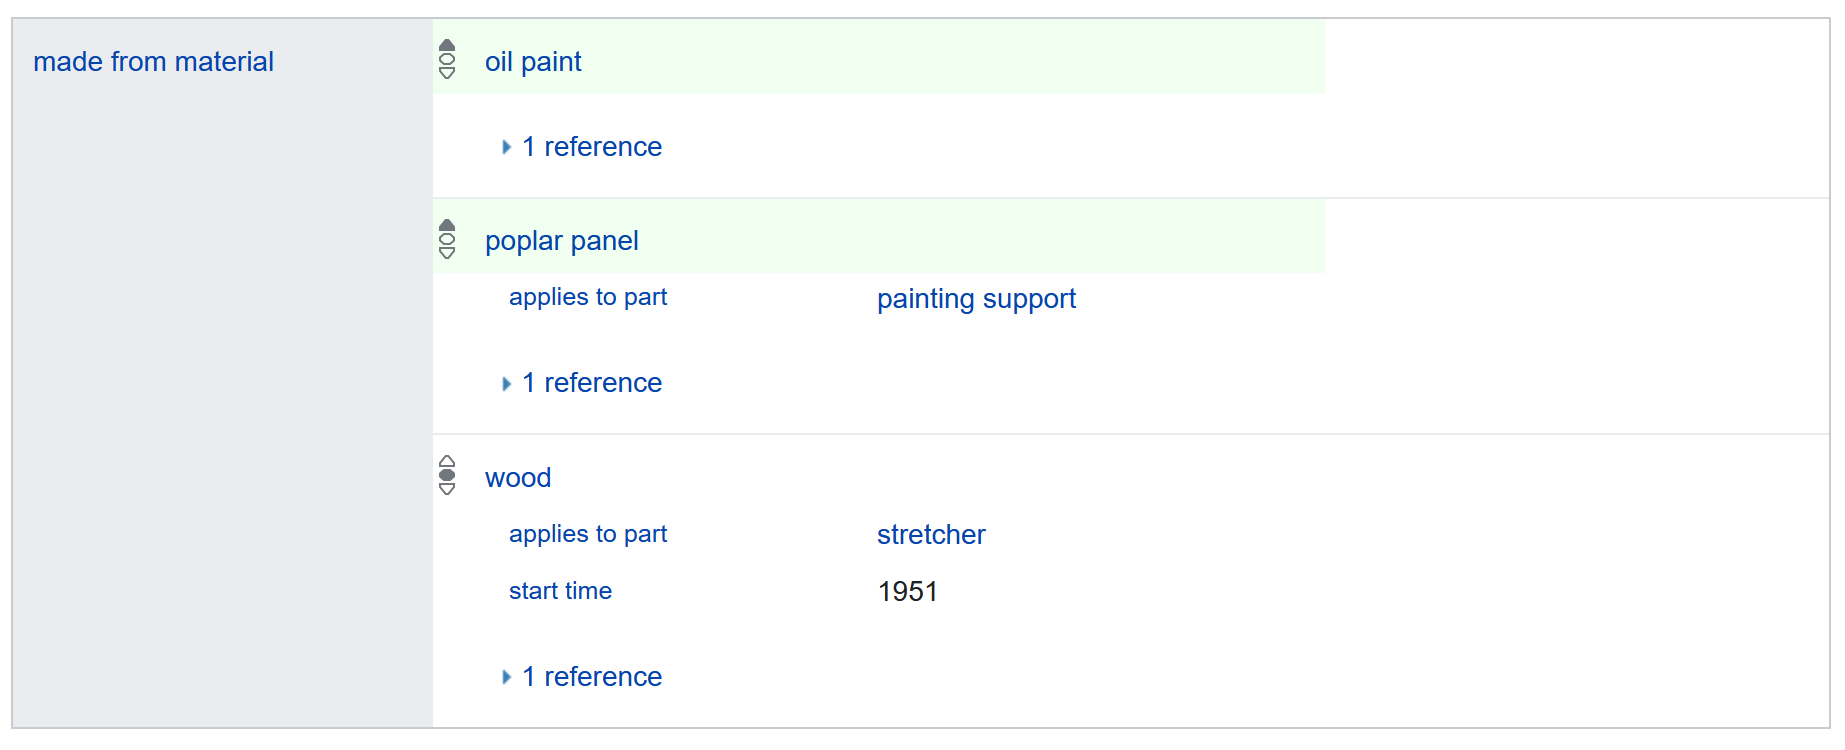

Note que tanto "poplar panel" como "wood" tienen el calificador "aplica a la parte" para indicar que el material es usado no en la globalidad de la pintura, sino que para una parte específica.

Para consultar estos calificadores, debemos usar propiedades con otro prefijo. Hasta ahora hemos usado `wdt:` para propiedades. Ahora usaremos `p`, que apunta no a un objeto, sino que a un "nodo de statement". Este nodo es el sujeto de otros triples, en donde el prefijo `ps:` (de **p**roperty **s**tatement) apunta al objeto del statement, y el prefijo the prefix `pq:` (**p**roperty **q**ualifier) apunta a los calificadores.

```sparql
wd:Q12418 p:P186 ?statement1.    # Mona Lisa: material usado: ?statement1
?statement1 ps:P186 wd:Q296955.  # valor: oil paint

wd:Q12418 p:P186 ?statement2.    # Mona Lisa: material usado: ?statement2
?statement2 ps:P186 wd:Q291034.  # valor: poplar panel
?statement2 pq:P518 wd:Q861259.  # calificador: applies to part: painting support

wd:Q12418 p:P186 ?statement3.    # Mona Lisa: material usado: ?statement3
?statement3 ps:P186 wd:Q287.     # valor: wood
?statement3 pq:P518 wd:Q1737943. # calificador: applies to part: stretcher
?statement3 pq:P580 1951.        # calificador: start time: 1951
```

La siguiente consulta pide todas las pinturas y los materiales de su superficie:

```sparql
SELECT ?pintura ?pinturaLabel ?material ?materialLabel WHERE {
  ?pintura wdt:P31/wdt:P279* wd:Q3305213; #instancia/subclase* de pintura (painting)
           p:P186 [
              ps:P186 ?material;
              pq:P518 wd:Q861259 #applies to part: superficie de pintura
           ].
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```
(Retorna muchos resultados, si no funciona agregar `LIMIT 100` al final de la consulta).

#### Referencias:

La siguiente consulta obtiene las URL de referencias para los valores de expectativa de vida de los países de Wikidata:

```sparql
SELECT ?ev ?anho ?url ?cLabel WHERE {
  ?c wdt:P31/wdt:P279* wd:Q6256 ; # Países
     p:P2250 [
       ps:P2250 ?ev ;
       pq:P585 ?anho ;
       prov:wasDerivedFrom [
           pr:P854 ?url
       ]       
     ]
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" . }
}
```

### Agregación y agrupamiento

Muchas veces queremos calcular estadísticas en vez de obtener listas enormes de resultados. Para esto podemos agrupar filas que tengan el mismo valor en alguna(s) de la(s) variable(s). Por ejemplo, para contar cuántas pinturas por tipo de material hay, podemos escribir:

```sparql
SELECT ?material (COUNT(?pintura) AS ?c) WHERE {
  ?pintura wdt:P31/wdt:P279* wd:Q3305213; #instancia/subclase* de pintura (painting)
           p:P186 [
              ps:P186 ?material;
              pq:P518 wd:Q861259 #applies to part: superficie de pintura
           ].
}
GROUP BY ?material
```

Se pueden ordenar los materiales de mayor a menor cantidad de pinturas usando `ORDER BY DESC(?c)`. Notará que no tenemos las etiquetas de cada material, podemos obtenerlas con la cláusula `SERVICE` de siempre, pero debemos agregar la variable de la etiqueta al `GROUP BY` para poder agregar la variable también en el `SELECT`

```sparql
SELECT ?material ?materialLabel (COUNT(?pintura) AS ?c) WHERE {
  ?pintura wdt:P31/wdt:P279* wd:Q3305213; #instancia/subclase* de pintura (painting)
           p:P186 [
              ps:P186 ?material;
              pq:P518 wd:Q861259 #applies to part: superficie de pintura
           ].
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
GROUP BY ?material ?materialLabel
```

### Visualizaciones

Algunos resultados de consulta se pueden mostrar como visualización (gráfico de barras, scatterplot, mapa) directamente en el terminal de consulta.

Por ejemplo, podemos buscar datos de calidad de vida de los países y graficar su distribución. La siguiente consulta busca la expectativa de vida y el índice de desarrollo humano para cada país:

```sparql
SELECT ?ev ?hdi ?cLabel WHERE {
  ?c wdt:P31/wdt:P279* wd:Q6256 ; # Países
     wdt:P2250 ?ev ; #esperanza de vida
     wdt:P1081 ?hdi . #indice de desarrollo humano
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" . }
}
```
Luego, en donde dice Table, podemos elegir "Scatter Chart" y nos mostrará dos ejes numéricos, y podemos ver a qué país corresponde cada punto poniendo el mouse encima de él. Note que en la consulta ponemos primero los valores numéricos para que el gráfico los use como ejes X e Y.

La siguiente consulta retorna las coordenadas de las estaciones de la Línea 1 del Metro de Santiago:

```sparql
SELECT ?item ?itemLabel ?coords{
  ?item wdt:P31/wdt:P279* wd:Q928830 ; #instancia/subclase* de estación de metro
        wdt:P81 wd:Q4215382  ; #pertenece a Línea 1 del MEtro de Santiago
        wdt:P625 ?coords . #coordenadas geográficas
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" . }
}
```

Luego se puede seleccionar, en vez de tabla, mapa, para ver las ubicaciones de las estaciones a lo largo de Santiago.

## Consultas vía Python

Como Wikidata provee una API para recibir consultas, lo único que necesitamos es el paquete `requests` de python para enviar una petición a Wikidata y obtener de vuelta un JSON, el cual luego podemos cargar en un dataframe o alguna otra estructura tabular.

In [2]:
#primero importamos las librerías a utilizar e inicializamos los parámetros y consulta
import requests

url = 'https://query.wikidata.org/sparql'

query = """
SELECT ?hijo ?hijoLabel WHERE {
  ?hijo wdt:P22 wd:Q1339;
         wdt:P106 wd:Q36834, wd:Q486748.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
"""

In [3]:
# enviamos la petición a Wikidata y obtenemos un JSON de vuelta

r = requests.get(url, params = {'format': 'json', 'query': query}) #otras opciones de formato: csv, tsv, html
data = r.json()

In [5]:
#código para importar el json a un dataframe
import pandas as pd
from collections import OrderedDict

hijos = []
for item in data['results']['bindings']: #esta parte es estándar, sin importar la consulta.
    hijos.append(OrderedDict({
        'hijo': item['hijo']['value'], #para cada variable ?x, utilizar item['x']['value'] para sacar el valor de esa variable.
        'label': item['hijoLabel']['value']}))
df = pd.DataFrame(hijos)
df.head()

,hijo,label
0,http://www.wikidata.org/entity/Q106641,Q106641
1,http://www.wikidata.org/entity/Q107277,Q107277
2,http://www.wikidata.org/entity/Q710996,Q710996
